## **[How to Tune the Perfect Smoother](https://medium.com/towards-data-science/how-to-tune-the-perfect-smoother-bcc5a67660b1)**
#### **Get the most out of your data with Whittaker-Eilers smoothing and leave-one-out cross validation**

In a previous article I introduced the Whittaker-Eilers smoother¹ as [The Perfect Way to Smooth Your Noisy Data](./27_The_Perfect_Way_to_Smooth_Your_Noisy_Data.ipynb). In a few lines of code, the method provides quick and reliable smoothing with inbuilt interpolation that can handle large stretches of missing data. Furthermore, just a single parameter, λ (lambda), controls how smooth your data becomes. You’ll find that any smoother will have such parameters and tuning them can be tremendously tedious. So, let me show you just how painless it can be with the right method.

#### **Whittaker-Eilers Smoothing**
When smoothing data, it’s likely there’s no ground truth you’re aiming towards; just some noise in your measurements that hamper attempts to analyse it. Using the Whittaker smoother, we can vary λ to alter the level of noise removed from our data.

<center> <p>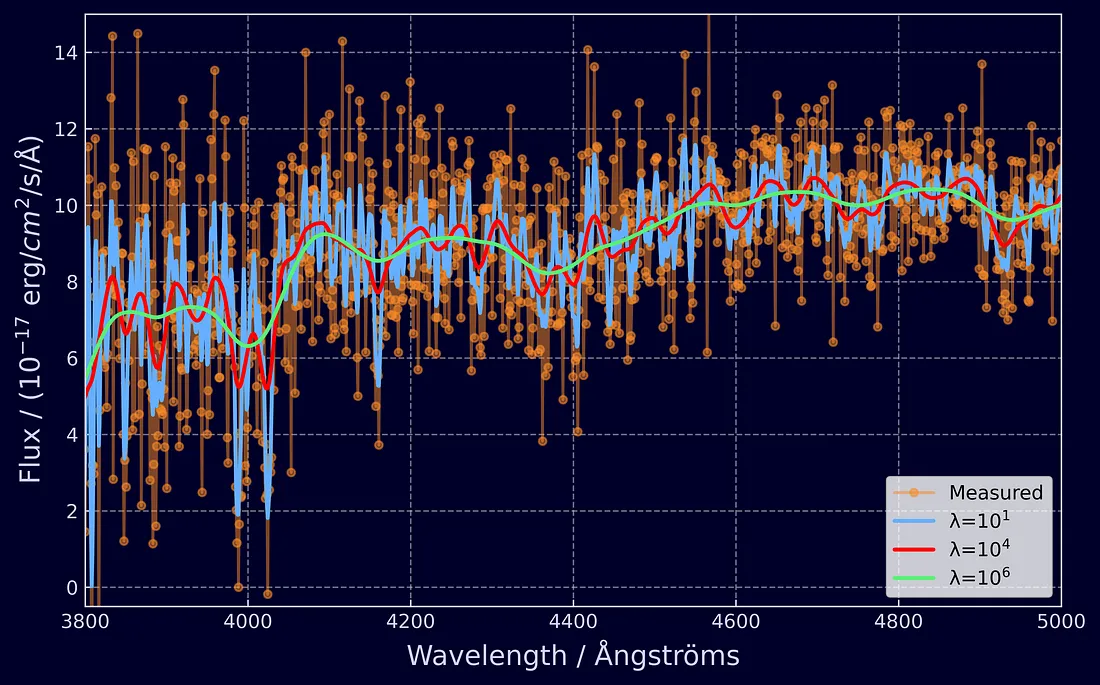</p> </center><font size = "3"><center> Figure 1) Optical output of a galaxy smoothed for three different \lambda s using the Whittaker-Eilers smoother. </center></font>

With λ ranging from 10 to 10,000,000 in Figure 1, how do we know what value would be most suitable for our data?

#### **Leave-one-out cross validation**

To get an idea of how effective the smoothing is at any given λ, we need a metric we can calculate from each smoothed series. As we’re unable to rely on having a ground truth, we’re going to estimate the standard *predictive squared error* (PSE) using *leave-one-out cross validation* (LOOCV). It’s a special case of k-fold cross validation where the number of folds, *k*, is equal to the length of your dataset, *n*.

The calculation is straightforward; we remove a measurement, smooth the series, and calculate the squared residual between our smoothed curve and the removed measurement. Repeat this for every measurement in the data, take an average and voila, we’ve calculated the *leave-one-out cross validation error* (CVE) — our estimation of the predictive squared error.

<center> <p>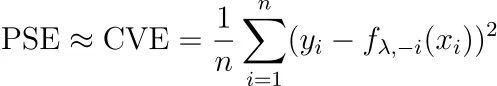</p> </center><font size = "3"><center>  </center></font>

> *In the equation above, our function f is the smoother and the -i notation denotes that we’ve smoothed our data leaving out the ith measurement. From here on, I’ll also utilise the root cross validation error (RCVE) which is just the square root of our cross validation error.*

We can now smooth the optical spectra again, calculating the cross validation error for a variety of λs. Then we can select the λ that produces the lowest cross validation error.

<center> <p>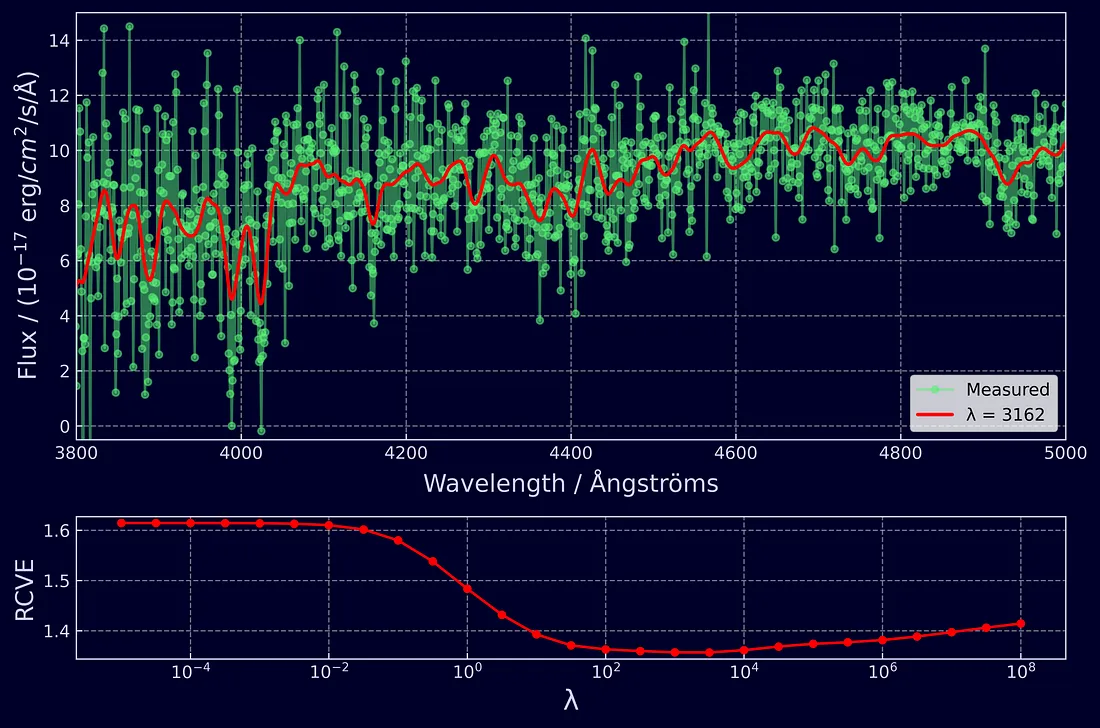</p> </center><font size = "3"><center> Figure 2) Optical spectra smoothed with the optimal \Lambda as chosen by the minimum cross validation error. </center></font>

In Figure 2 you can see the root cross validation error plotted against λ. For this specific data series a λ of ~10³ results in the optimal configuration.

Within the whittaker-eilers [Python](https://pypi.org/project/whittaker-eilers/) and Rust packages I’ve implemented this as a single function which performs a search of λ and returns the optimally smoothed series alongside all of the λs and cross validation errors.

> ***Python:*** *pip install whittaker-eilers*

In [ ]:
from whittaker_eilers import WhittakerSmoother


data_to_smooth = [6.7, 8.0, 2.1, 8.4, 7.6, 3.4]

smoother = WhittakerSmoother(lmbda=1, order=2, data_length=len(data_to_smooth))

results = smoother.smooth_optimal(data_to_smooth, break_serial_correlation=False)

optimally_smoothed_series = results.get_optimal().get_smoothed()
optimal_lambda = results.get_optimal().get_lambda()

#### **Has cross validation produced a good result?**

With a little domain knowledge, we can double check our smoothed result from cross validation. On the left of Figure 2, at a wavelength of around 4000 Ångströms, there’s two dips which align with the absorption lines for Potassium and Hydrogen, alongside a Hydrogen emission line.

<center> <p>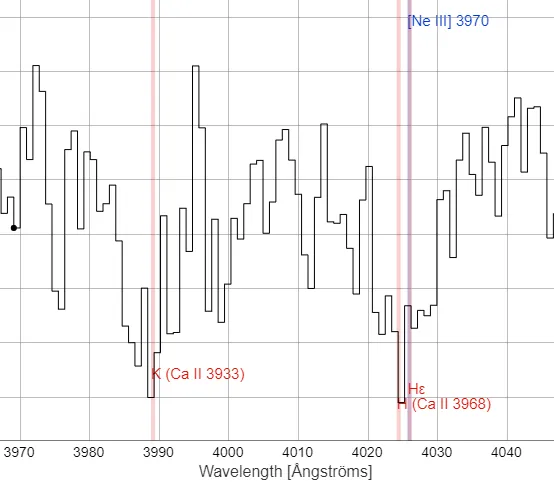</p> </center><font size = "3"><center> Figure 3) Close up of the optical spectra with the emission and absorption lines overlaid from the SDSS website </center></font>

Over-smoothing results in these dips being merged and under-smoothing leaves the dips separate but very noisy. Leave-one-out cross validation has done an excellent job of selecting a λ which removes the vast majority of the noise while preserving the underlying signal.

#### **More examples**
Let’s take a look at more data smoothed with the optimal λ as selected by leave-one-out cross validation.

<center> <p>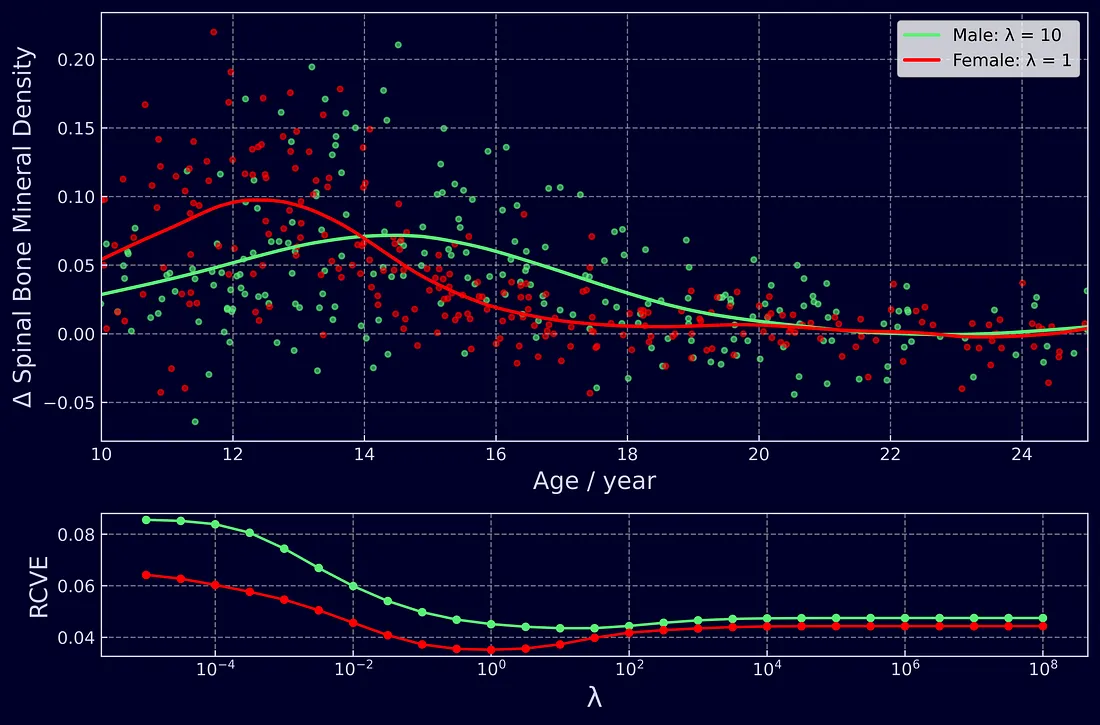</p> </center><font size = "3"><center> Figure 4) Optimally smoothed change in mineral bone density and root cross validation error for the \lambda s tested. This is an example of how the Whittaker can be used to smooth a scatter plot. </center></font>

The first of the two datasets is rather noisy and therefore small values of λ have generated the largest cross validation errors. Conversely, the second dataset isn’t very noisy at all and has resulted in larger λs being penalised much more than smaller λs.

> *It’s worth noting that λ can vary across datasets not only due to noise, but also due to the sampling rate of the measurements.*

#### **The Achilles heel of cross validation**

Serially correlated data — when data is correlated with the lagged version of itself — causes a significant problem when using leave-one-out cross validation. Cross validation requires measurement error to be independent (like most statistical techniques) but, in serially correlated data measurement errors are likely dependent on the previous one. In practicality this leads to data barely being smoothed as only at that scale are the errors independent.

Eilers presents a quick solution to this whereby you sample the data series at every 5th (or 10th or 20th) point effectively removing the serial correlation from your data¹. In the previous code snippets you can see I’ve implemented this by exposing a Boolean option named *“break_serial_correlation”*. This was left off to smooth the optical spectra in Figure 3 as no serial correlation is present but turned on for smoothing the humidity data Figure 5. It makes for a good solution, but not a perfect one.

#### **As good as a ground truth?**

Generally when you want to assess how well a model fits your data, you’ll use a metric such as *root mean squared error* (RMSE) to calculate the difference in your model’s estimations against a ground truth. So let’s generate a few data series with varying levels of noise and compare how the RMSE reacts in comparison to our leave-one-out cross validation error.

<center> <p>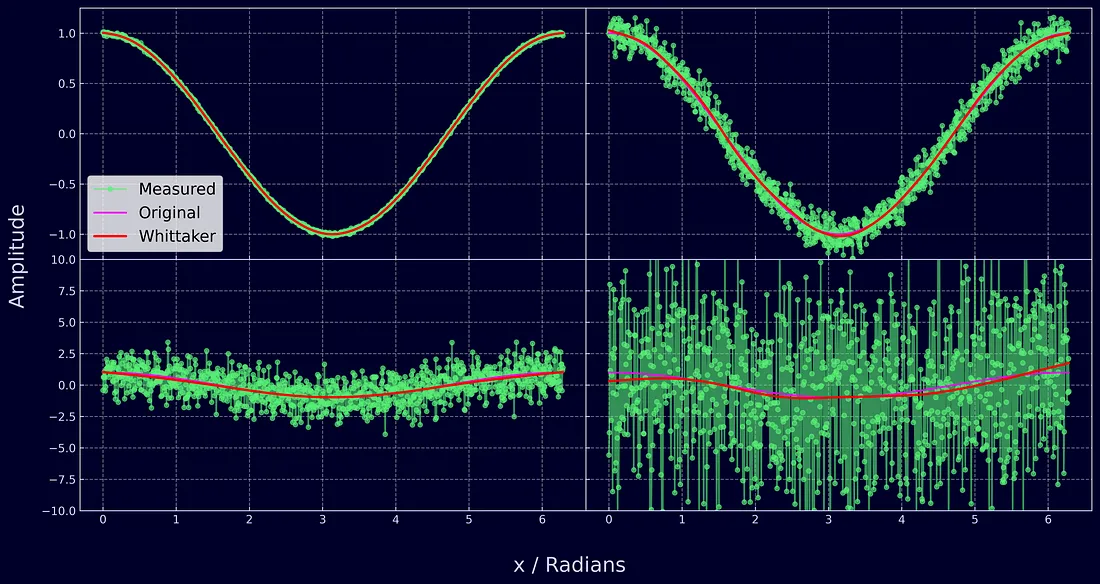</p> </center><font size = "3"><center> Figure 6) Cosine function between 0 and 2\pi with varying levels of Gaussian noise added and then smoothed using the optimally tuned Whittaker. </center></font>

<center> <p>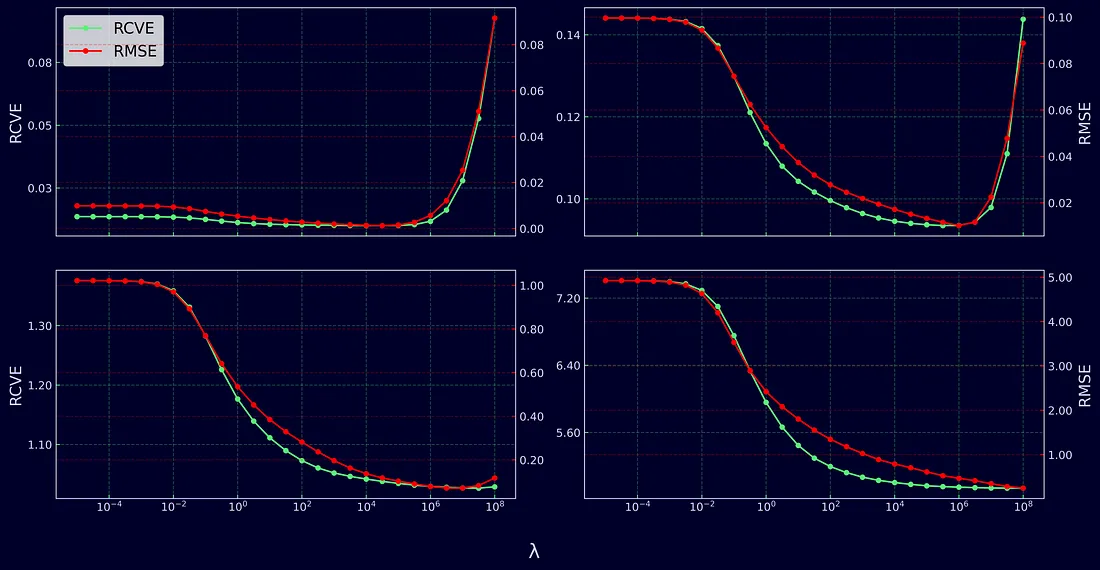</p> </center><font size = "3"><center> Figure 7) The root cross validation error (RCVE) and the root mean squared error (RMSE) plotted against 貫 on the same graph with separately scaled axes. </center></font>

As is expected, when the error added to the measurements gets larger the optimal λ selected is larger too, inducing more smoothing on the series. An approximately linear relationship between the RCVE and RMSE can be seen with the two offset by some constant. This aligns with what is expected from the literature⁵ as CVE is our estimate of *predictive squared error* (PSE) which is related to mean squared error by,

<center> <p></p> </center><font size = "3"><center>  </center></font>

where σ is the standard deviation of the residuals. What we’ve proved here is that in the case of actually random, independent errors, leave-one-out cross validation offers a good estimation of the predictive squared error and in turn, the overall quality of the smoothed fit.

#### **Cross validation is slow. Let’s speed it up**

Earlier in this article, I provided the formula to compute cross validation error. Following it exactly would require you to smooth a data series of *n-1* length *n* times which, even with a quick method, is not ideal. Luckily for us the Whittaker is a *constant preserving linear smoother* which enables us to derive an amazing relationship between the ordinary residuals and the leave-one-out cross validation residuals⁵. The result of this relationship? **Only having to smooth the data once to compute the cross validation error.** Let’s dive right in.

[I’ve previously demonstrated the linear algebra behind the Whittaker smoother](https://towardsdatascience.com/the-perfect-way-to-smooth-your-noisy-data-4f3fe6b44440#:~:text=of%20pre%2Dprocessing!-,The%20Mathematics,-Now%20we%E2%80%99ve%20covered) and how; by calculating the ordinary residuals between your smoothed series **z** and your original series **y**,

<center> <p>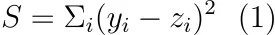</p> </center><font size = "3"><center>  </center></font>

and then balancing them with a measure of smoothness — the sum of squared differences between adjacent points in the smoothed series,

<center> <p>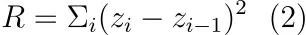</p> </center><font size = "3"><center>  </center></font>

you end up with equation 3, where **λ** is a used to scale the scale the smoothness of your data.

<center> <p>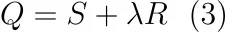</p> </center><font size = "3"><center>  </center></font>

Minimising **Q** then results in the optimally smoothed series for any given **λ**, which can be boiled down to a least squares problem resulting in the following linear equation,

<center> <p>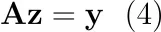</p> </center><font size = "3"><center>  </center></font>

where **y** is a vector of raw points, **z** a vector of smoothed points, and **A** a matrix containing some information about your smoothing constant **λ**. We can shuffle this about,

<center> <p>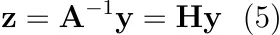</p> </center><font size = "3"><center>  </center></font>

and arrive at a generic equation that describes a *linear smoother*. **H** throughout regression and smoothing literature is called the *smoother matrix* or *hat matrix* — which makes a lot of sense as multiplying our series **y** by **H** results in a smoothed series **z** (and in some notations **ŷ** instead, hence hat matrix)¹. The smoother matrix is important as it forms the basis of the relationship between our ordinary residuals and the leave-one-out cross validation residuals.

Let’s revisit the statement I made at the start of the section. The Whittaker smoother is *constant preserving*; meaning that the smoother isn’t adding a bias to the underlying signal. Due to this, we can assume each row in the smoother matrix sums to 1. If it didn’t, when you multiplied it with your raw points, it would shift the smoothed series away from the underlying signal in the data. Relating this back to how we calculate the cross validated smoothed series gives us a starting point for the derivation. When we remove a point from our series, we have to remove a column from **H**. A row therefore contains one fewer element and needs to be re-normalised to sum to 1. We can formalise this as

<center> <p>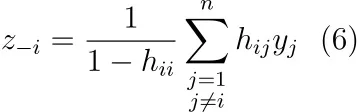</p> </center><font size = "3"><center>  </center></font>

where **h** is an element of our smoother matrix **H**, and we’re really just describing a matrix multiplication which skips a column⁵. The *-i* notation here is the same as in the CVE equation from earlier — it’s the predicted value for ith element where *yᵢ* hasn’t been used to calculate the fit.

We now want to try and find a relationship between the ordinary residuals (computed between the smoothed series and raw series) and the leave-one-out cross validation residuals (computed between the smoothed series produced with an input point missing and the raw series). Let’s first expand and rearrange to get rid of the ugly notation in the summation.

<center> <p>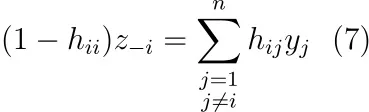</p> </center><font size = "3"><center>  </center></font>

<center> <p>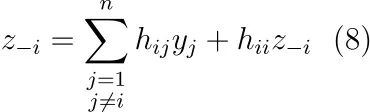</p> </center><font size = "3"><center>  </center></font>

<center> <p>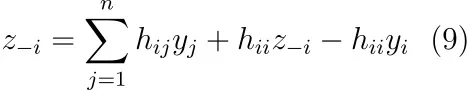</p> </center><font size = "3"><center>  </center></font>

The summation is now taking into account all elements and becomes the equation that produces our standard smoothed value **z**,

<center> <p>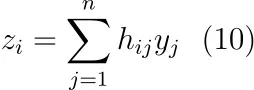</p> </center><font size = "3"><center>  </center></font>

which can then be substituted in,

<center> <p>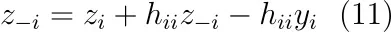</p> </center><font size = "3"><center>  </center></font>

<center> <p>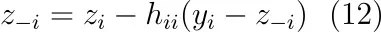</p> </center><font size = "3"><center>  </center></font>

<center> <p>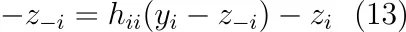</p> </center><font size = "3"><center>  </center></font>

<center> <p>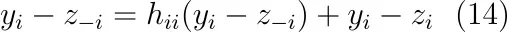</p> </center><font size = "3"><center>  </center></font>

<center> <p>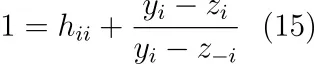</p> </center><font size = "3"><center>  </center></font>

<center> <p>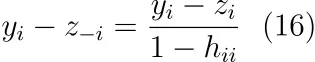</p> </center><font size = "3"><center>  </center></font>

eventually resulting in a direct relationship between the leave-one-out cross validation residuals and the ordinary residuals via the diagonal of the smoother matrix. Pretty neat. We can now take our original equation for CVE and plug in our new relationship,

<center> <p>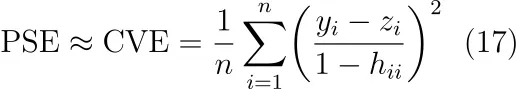</p> </center><font size = "3"><center>  </center></font>

and as you can see, we now don’t need to smooth the series each time! We just access an element of our smoother matrix diagonal⁵. This leads neatly onto the equation for *generalised cross validation* where, instead of dividing by each diagonal element of **H**, we calculate the mean of the diagonal and divide by that instead³.

<center> <p>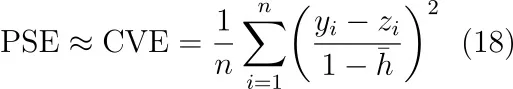</p> </center><font size = "3"><center>  </center></font>

#### **Why this is still too slow**

In calculating the smoother matrix we need to invert a sparse matrix — which unfortunately results in a dense matrix. As our data length grows, the dense smoother matrix will grow by n². While calculating this is still quicker than smoothing our series n times, it’s not as fast as it could be. Eilers observes that the diagonal of H plots a similar shape for a series of any length, it just needs to be scaled accordingly by the ratio of the lengths¹. What we’re essentially doing is creating a sample from H we’ll use to get our average of the full H’s diagonal. Implementing this for a sample size of 100 enables us to have consistently quick way of calculating the cross validation error.

<center> <p>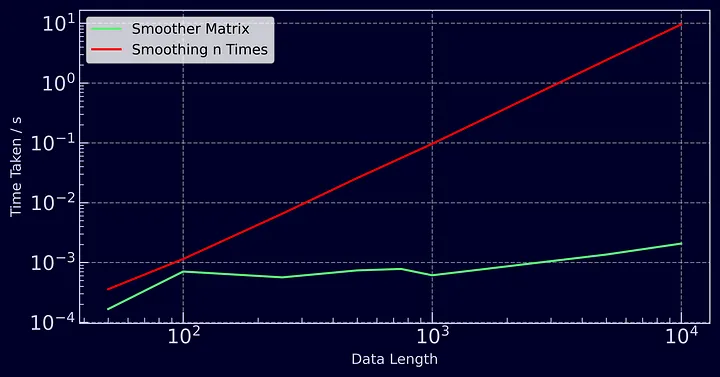</p> </center><font size = "3"><center> Figure 8) The time taken to smooth a series of n length using the optimised smoother matrix method and by simply smoothing the data series of n-1 length n times. </center></font>

In Figure 8 we can see that if we were to use the original equation for CVE, smoothing our data series n times, the time complexity increases with n² — as does when we’re calculating the the smoother matrix up to a length of 100. Kicking sampling in after n=100 enables us to increase the length of the series for little additional cost. This sampling is likely responsible for the small differences between RCVE and the RMSE in Figure 7.

#### **Concluding thoughts and further reading**

The Whittaker-Eilers method is an amazing tool for both smoothing and interpolating noisy data. Implementing it with sparse matrices results in an incredibly quick and memory efficient method allowing for fast cross validation which, in the absence of a ground truth, is an effective measure of the smoother’s performance.

In the case of serially correlated data, cross validation can still be a good method when slightly tweaked. Ultimately, more complex methods such as L- and V-curve optimisation are better suited to parameter selection on this sort of data. Maybe some time soon I’ll get round to implementing them in the whittaker-eilers package.

All of the code which has been used to generate these results is available within the [whittaker-eilers GitHub repository](https://github.com/AnBowell/whittaker-eilers) where both the Python and Rust packages reside. I’ve also included Eilers original MATLAB scripts used to implement the Whittaker and cross validation¹.

#### **References**

[1] Eilers, Paul H. C., A Perfect Smoother, Analytical Chemistry 2003 75 (14), 3631–3636, DOI: 10.1021/ac034173t

[2] Kollmeier et al, SDSS-V Pioneering Panoptic Spectroscopy, Bulletin of the American Astronomical Society, 2019 51 (7), 274, Bibcode: 2019BAAS…51g.274K

[3] Hastie T, Tibshirani T, Friedman J, The Elements of Statistical Learning, Springer, 2009, URL: https://hastie.su.domains/ElemStatLearn/

[4] Vito, Saverio, Air Quality, UCI Machine Learning Repository, 2016, DOI: 10.24432/C59K5F Licence: Creative Commons Attribution 4.0 International

[5] Geyer, Charles J., 5601 Notes: Smoothing, University Of Minnesota, 2013, URL: https://www.stat.umn.edu/geyer/5601/notes/smoo.pdf